[Reference](https://medium.com/grabngoinfo/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9)

# Step 1: Install and Import Libraries

In [1]:
# Install libraries
!pip install yfinance prophet pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 52 kB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 199 kB 73.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=c11a95c2b83058bfe8649b77d0121f789e29f28d5d790651af655c821543ad9f
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

# Step 2: Pull Data

In [3]:
# Data start date
start_date = '2020-01-02'

# Data end date
end_date = '2022-01-01' # yfinance excludes the end date, so we need to add one day to the last day of data

In [16]:
# Download data
ticker_list = ['META', 'GOOG', 'ORCL', 'MSFT', 'AMZN']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Drop the top level column name
data.columns = data.columns.droplevel()

# Take a look at the data
data.head()

[*********************100%***********************]  5 of 5 completed


,AMZN,GOOG,META,MSFT,ORCL
Date,,,,,
2020-01-02,94.900497,68.368500,209.779999,160.619995,53.950001
2020-01-03,93.748497,68.032997,208.669998,158.619995,53.759998
2020-01-06,95.143997,69.710503,212.600006,159.029999,54.040001
2020-01-07,95.343002,69.667000,213.059998,157.580002,54.160000
2020-01-08,94.598503,70.216003,215.220001,160.089996,54.130001


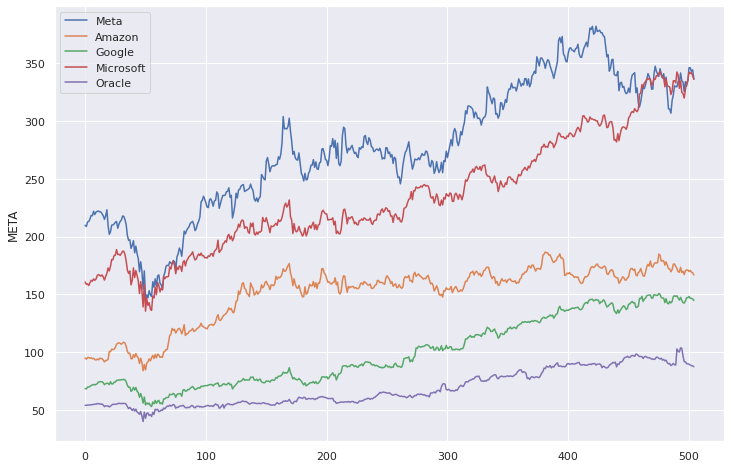

In [22]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['META'])
sns.lineplot(x=data.index, y=data['AMZN'])
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['MSFT'])
sns.lineplot(x=data.index, y=data['ORCL'])
plt.legend(labels = ['Meta', 'Amazon', 'Google', 'Microsoft', 'Oracle'])

In [23]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    505 non-null    datetime64[ns]
 1   AMZN    505 non-null    float64       
 2   GOOG    505 non-null    float64       
 3   META    505 non-null    float64       
 4   MSFT    505 non-null    float64       
 5   ORCL    505 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 23.8 KB


# Step 3: Data Processing

In [24]:
# Release Date from the index
data = data.reset_index()

# Change data from the wide format to the long format
df = pd.melt(data, id_vars='Date', value_vars=['AMZN', 'META', 'GOOG', 'MSFT', 'ORCL'])
df.columns = ['ds', 'ticker', 'y']
df.head()

,ds,ticker,y
0,2020-01-02,AMZN,94.900497
1,2020-01-03,AMZN,93.748497
2,2020-01-06,AMZN,95.143997
3,2020-01-07,AMZN,95.343002
4,2020-01-08,AMZN,94.598503


In [25]:
# Check the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2525 non-null   datetime64[ns]
 1   ticker  2525 non-null   object        
 2   y       2525 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 59.3+ KB


In [26]:
# Group the data by ticker
groups_by_ticker = df.groupby('ticker')

# Check the groups in the dataframe
groups_by_ticker.groups.keys()

dict_keys(['AMZN', 'GOOG', 'META', 'MSFT', 'ORCL'])

# Step 4: Define Function

In [27]:
def train_and_forecast(group):  
  
  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)  
  
  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]

# Step 5: Multiple Time Series Forecast Using For-Loop

In [28]:
# Start time
start_time = time()

# Create an empty dataframe
for_loop_forecast = pd.DataFrame()

# Loop through each ticker
for ticker in ticker_list:
  # Get the data for the ticker
  group = groups_by_ticker.get_group(ticker)  
  # Make forecast
  forecast = train_and_forecast(group)
  # Add the forecast results to the dataframe
  for_loop_forecast = pd.concat((for_loop_forecast, forecast))
  
print('The time used for the for-loop forecast is ', time()-start_time)

# Take a look at the data
for_loop_forecast.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwfsi_di/r84tjf73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwfsi_di/ktu7dd8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8429', 'data', 'file=/tmp/tmpmwfsi_di/r84tjf73.json', 'init=/tmp/tmpmwfsi_di/ktu7dd8z.json', 'output', 'file=/tmp/tmpvioayhir/prophet_model-20220824121337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:13:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with year

The time used for the for-loop forecast is  11.810548305511475


,ds,ticker,yhat,yhat_upper,yhat_lower
0,2020-01-02,META,224.550138,239.864454,210.401204
1,2020-01-03,META,224.069484,239.729622,209.483101
2,2020-01-06,META,221.447529,235.708652,206.190588
3,2020-01-07,META,221.791034,236.144077,206.322130
4,2020-01-08,META,221.152171,235.305116,205.114905


# Step 6: Multiple Time Series Forecast Using Multi-Processing

In [29]:
# Start time
start_time = time()# Get time series data for each ticker and save in a list
series = [groups_by_ticker.get_group(ticker) for ticker in ticker_list]# Create a pool process with the number of worker processes being the number of CPUs
p = Pool(cpu_count())# Make predictions for each ticker and save the results to a list
predictions = list(tqdm(p.imap(train_and_forecast, series), total=len(series)))# Terminate the pool process
p.close()# Tell the pool to wait till all the jobs are finished before exit
p.join()# Concatenate results
multiprocess_forecast = pd.concat(predictions)# Get the time used for the forecast
print('\nThe time used for the multi-processing forecast is ', time()-start_time)

  0%|          | 0/5 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwfsi_di/y2_jqc11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmwfsi_di/bhc3zq28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57154', 'data', 'file=/tmp/tmpmwfsi_di/y2_jqc11.json', 'init=/tmp/tmpmwfsi_di/bhc3zq28.json', 'output', 'file=/tmp/tmp17vezf30/prophet_model-20220824121349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:13:49 - cmdstanpy


The time used for the multi-processing forecast is  11.78057050704956


# Step 7: Multiple Time Series Forecast Using Spark

In [30]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [31]:
# Convert the pandas dataframe into a spark dataframe
sdf = spark.createDataFrame(df)# Define the restult schema
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('ticker',StringType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])# Start time
start_time = time()# Train and forecast by ticker 
spark_forecast = sdf.groupBy('ticker').applyInPandas(train_and_forecast, schema=result_schema)# Take a look at the results
spark_forecast.show(5)# Processing time
print('The time used for the Spark forecast is ', time()-start_time)

+----------+------+---------+----------+----------+
|        ds|ticker|     yhat|yhat_upper|yhat_lower|
+----------+------+---------+----------+----------+
|2020-01-02|  AMZN| 93.45303| 101.06227|  85.77086|
|2020-01-03|  AMZN|93.106895| 100.55787|  85.92406|
|2020-01-06|  AMZN| 93.19613| 100.59033|  85.62912|
|2020-01-07|  AMZN|93.848656| 101.61394|  86.23466|
|2020-01-08|  AMZN|94.076675| 101.46861|  86.58709|
+----------+------+---------+----------+----------+
only showing top 5 rows

The time used for the Spark forecast is  17.81201171875


In [32]:
@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def train_and_forecast(group):  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]  # Start time
start_time = time()# Train and forecast by ticker 
spark_forecast = sdf.groupBy('ticker').apply(train_and_forecast)# Take a look at the results
spark_forecast.show(5)# Processing time
print('The time used for the Spark forecast is ', time()-start_time)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/group_ops.py:102: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  UserWarning,


+----------+------+---------+----------+----------+
|        ds|ticker|     yhat|yhat_upper|yhat_lower|
+----------+------+---------+----------+----------+
|2020-01-02|  AMZN| 93.45303| 101.06227|  85.77086|
|2020-01-03|  AMZN|93.106895| 100.55787|  85.92406|
|2020-01-06|  AMZN| 93.19613| 100.59033|  85.62912|
|2020-01-07|  AMZN|93.848656| 101.61394|  86.23466|
|2020-01-08|  AMZN|94.076675| 101.46861|  86.58709|
+----------+------+---------+----------+----------+
only showing top 5 rows

The time used for the Spark forecast is  13.491744756698608


# Step 8: Which Method to use?
    When the number of models is small, there is not a big difference in processing time, so any one of the three methods is good to use.
    When the number of models is medium, use multi-processing or Spark to utilize multiple CPUs in parallel.
    When the number of models is large, Spark is preferred.